# Understanding convolutional layers in TensorFlow 2
## Christian Igel, 2020



In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

Load the MNIST data set of handwritten images. The training data set contains 60000 images of size $28\times 28$. For processing with the Keras convolutional layers, 2D images have to be three-dimensional objects. The third dimensions is for different channels, for example 3 in the case of color images (e.g., RGB channels). The MNIST images are monochrome, still we have to add a dimension to the shape of the input images.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0  # Map pixel values to [0,1]
no_channels = 1  # Monochrome images, just one color channel

print("Shape before adding channel dimension:", x_train.shape)
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print("Shape after adding channel dimension:", x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
Shape before adding channel dimension: (60000, 28, 28)
Shape after adding channel dimension: (60000, 28, 28, 1)


Now we pick and visualize a single example input image - the first one.

In [3]:
img = x_train[0]
img_width = img.shape[0]
img_height = img.shape[1]
print("Input image has width", img_width, "and height", img_height)

Input image has width 28 and height 28


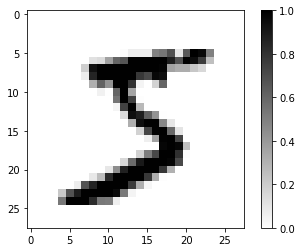

In [4]:
# imshow does not want the channel dimension for monochrome images, so we remove it again for plotting
plt.imshow(img.squeeze(), cmap='binary');  # squeeze removes "single-dimensional entries from the shape of an array"
plt.colorbar();

Now we define a model that consists of only a single convolutional layer. As we are only interesetd in the convolution, we do not apply a non-linear activation function and do not use a bias parameter (`activation=None, use_bias=False`).

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (2, 1), padding='valid', activation=None, use_bias=False,
                           input_shape=(img_width, img_height, no_channels))
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 28, 1)         2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
#tf.keras.layers.Conv2D?

Now we overwrite the weights (parameters) of the convolution kernel (filter mask).
Alternatively, we could have used a constant initialization in the model definition as shown below.

In [7]:
print("Initial weights:", model.layers[0].weights)
y_grad = np.array([-1,1]).reshape(2,1,1,1)
print(y_grad.shape)
model.layers[0].set_weights([y_grad])
print("New weights:", model.layers[0].weights)

Initial weights: [<tf.Variable 'conv2d/kernel:0' shape=(2, 1, 1, 1) dtype=float32, numpy=
array([[[[-0.49835825]]],


       [[[ 0.83800685]]]], dtype=float32)>]
(2, 1, 1, 1)
New weights: [<tf.Variable 'conv2d/kernel:0' shape=(2, 1, 1, 1) dtype=float32, numpy=
array([[[[-1.]]],


       [[[ 1.]]]], dtype=float32)>]


We need to compile the model to evaluate it.

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='sgd')  # loss and optimizer do not matter in the following

Now we can apply the model to the input image:

In [9]:
result = model(img.reshape(1,28,28,1))
print("Shape of the result:", result.shape)

Shape of the result: (1, 27, 28, 1)


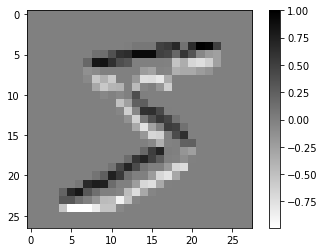

In [10]:
plt.imshow(result.numpy().squeeze(), cmap='binary');  # Plot is rescaled, we have negative values in the image
plt.colorbar();

No we define a layer producing two output maps:

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(2, (2, 2), activation=None, use_bias=False,
                           input_shape=(img_width, img_height, no_channels))
    ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 27, 2)         8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


Now the layer has two filter masks. We set the first to react to vertical edges and the other one to horzontal edges. 


In [12]:
y_grad = np.array([[-1,1],[-1,1]]).reshape(2,2,1)
x_grad = np.array([[-1,-1],[1,1]]).reshape(2,2,1)
y_and_x_grad = np.stack((y_grad, x_grad), axis=-1)
print("Shape of filters:", y_and_x_grad.shape)
print("Filters:", y_and_x_grad)


model.layers[0].set_weights([y_and_x_grad])
print("New weights:", model.layers[0].
      weights)

Shape of filters: (2, 2, 1, 2)
Filters: [[[[-1 -1]]

  [[ 1 -1]]]


 [[[-1  1]]

  [[ 1  1]]]]
New weights: [<tf.Variable 'conv2d_1/kernel:0' shape=(2, 2, 1, 2) dtype=float32, numpy=
array([[[[-1., -1.]],

        [[ 1., -1.]]],


       [[[-1.,  1.]],

        [[ 1.,  1.]]]], dtype=float32)>]


Compile model before applying it:

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='sgd')

The model produces two feature maps/channels. 

In [14]:
result = model(img.reshape(1,28,28,1))
print("Shape of the result:", result.shape)
print('Number of input images ("batch size"):', result.shape[0])
print('Number of feature maps/channels:', result.shape[-1])
print('Dimension of image:', tf.squeeze(result)[:,:,0].shape)

Shape of the result: (1, 27, 27, 2)
Number of input images ("batch size"): 1
Number of feature maps/channels: 2
Dimension of image: (27, 27)


Output after convolution with first filter:


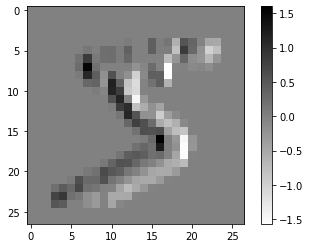

In [15]:
print("Output after convolution with first filter:")
plt.imshow(tf.squeeze(result)[:,:,0], cmap='binary');
plt.colorbar();

Output after convolution with second filter:


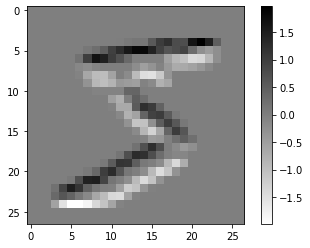

In [16]:
print("Output after convolution with second filter:")
plt.imshow(tf.squeeze(result)[:,:,1], cmap='binary');
plt.colorbar();

Now we define the kernel in the model defnition. Furthermore, we add a non-linearity after the convolution. We compute the absolute value $x\mapsto |x|$. 

Shape of result: (1, 27, 28, 1)


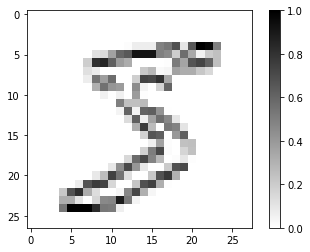

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (2, 1), activation=tf.keras.backend.abs, use_bias=False,
                           input_shape=(img_width, img_height, no_channels),
                           kernel_initializer=tf.initializers.constant([[[[-1]]],[[[1]]]]))
    ])
model.compile(loss='categorical_crossentropy', optimizer='sgd')
result = model(img.reshape(1,28,28,1))
print("Shape of result:", result.shape)
plt.imshow(tf.squeeze(result), cmap='binary'); 
plt.colorbar();

Padding with `padding='same'` adds rows and columns of zeros at the top, bottom, left and right side of the image tensor so that the results of the convolutions have the same spatial dimensions as the input:

Shape of result: (1, 28, 28, 1)


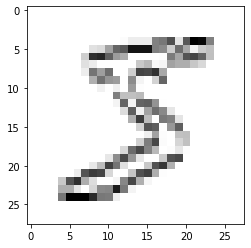

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (2, 1), activation=tf.keras.backend.abs, use_bias=False,
                           padding='same',  # Ouput map has smae size as inout map
                           input_shape=(img_width, img_height, no_channels),
                           kernel_initializer=tf.initializers.constant([[[[-1]]],[[[1]]]]))
    ])
model.compile(loss='categorical_crossentropy', optimizer='sgd')
result = model(img.reshape(1,28,28,1))
print("Shape of result:", result.shape)
plt.imshow(tf.squeeze(result), cmap='binary'); 

Strided convolution correpsonds to to convolution followed by subsampling: 

Shape of result: (1, 14, 14, 1)


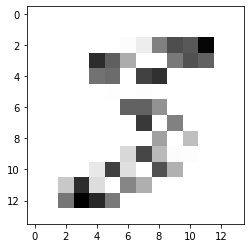

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (2, 1), activation=tf.keras.backend.abs, use_bias=False,
                           padding='same',  # Ouput map has smae size as inout map
                           strides=(2,2),  # Corresponds to convolution followed by subsampling
                           input_shape=(img_width, img_height, no_channels),
                           kernel_initializer=tf.initializers.constant([[[[-1]]],[[[1]]]]))
    ])
model.compile(loss='categorical_crossentropy', optimizer='sgd')
result = model(img.reshape(1,28,28,1))
print("Shape of result:", result.shape)
plt.imshow(tf.squeeze(result), cmap='binary'); 